In [5]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
# from dpp import DPP
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair

from experiments.make_flow import make_wrapped_normflow_realnvp
from tqdm import tqdm

import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 2.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

In [3]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

In [6]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pytorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

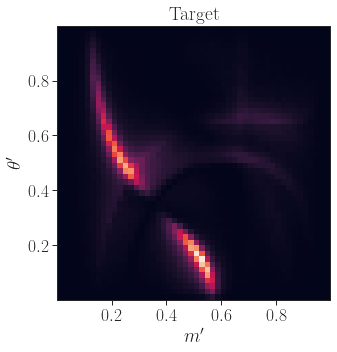

In [11]:
n_samples = 1000000

# Visualize 2D Dalitz plot
fig, ax1 = plt.subplots(1, 1, figsize=(9,5))

h, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 50)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

### Model v1

In [13]:
# Define the flow
n_flow_layers = 20
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 7
metropolis_step_size = 0.1

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target.

## Model v2

In [15]:
# Define the flow
n_flow_layers = 20
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 4
metropolis_step_size = 0.2

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target.

In [17]:
dim = 2
seed = 0

# Define the flow
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                     layer_nodes_per_dim=layer_nodes_per_dim,
                                     act_norm=False)

/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:663: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1925.)
  LU, pivots, infos = torch._lu_with_info(


In [ ]:
# Define the transistion operator
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
        n_outer=1,
        epsilon=1.0, L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        p_target=p_target,
        alpha=alpha,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=True)
else:
    raise NotImplementedError

NameError: name 'target' is not defined